In [364]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

# from ALT_F_BIND_chromo_vertex_nuclear_competitive_2_density import *

In [2]:
# chrmosome 16, Gm12878
# 1) process chr 16 Gm12878 chipseq data according to quinn Bottom up modeling paper- should roughly match DONE
#     bigwig file from quinn bottom up paper, then converted to bedGraph using bigWigToBedGraph from UCSC command line tool on WSL

# 2) Generate binding profile TODO

# 3) find chr 16 intrachromosome Hi-C data DONE 
#     from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE63525
#     linked in paper : A 3D map of the human genome at kilobase resolution reveals principles of chromatin looping
#     itself linked in paper : In silico prediction of high-resolution Hi-C interaction matrices,
#         which used Random forests to predict Hi-C from genomic data

# 4) train neural net!


# 1) Get H3K9me3 mark profile

In [3]:
# h3k9me3_data = pd.read_csv('wgEncodeBroadHistoneGm12878H3k9me3StdAln.narrowPeak', sep="\t", header=None)
# h3k9me3_data.columns = ["chromosome", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak"]

# h3k9me3_data = pd.read_csv('ENCFF519VDJ.bed', sep="\t", header=None)
# h3k9me3_data.columns = ["chromosome", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak"]

# bigwig file from quinn bottom up paper, then converted to bedgraph using bigWigToBedGraph from UCSC command line tool on WSL
h3k9me3_data = pd.read_csv('output.bedGraph', sep="\t", header=None)
h3k9me3_data.columns = ["chromosome", "start", "end", "value"]

In [107]:
# isolate chromosome 16
chr16_h3k9me3_data = h3k9me3_data[h3k9me3_data["chromosome"] == "chr16"] #.groupby("chromosome")
chr16_h3k9me3_data.sort_values("start", inplace=True)
# chr16_h3k9me3_data#head()

C:\Users\tmhab\AppData\Local\Temp\ipykernel_21496\1480449248.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr16_h3k9me3_data.sort_values("start", inplace=True)


In [72]:
%%time
# convert matrix of ranges into 1d array

# 1. Determine the size of the array
array_size = chr16_h3k9me3_data['end'].max()

# 2. Initialize the 1D array with zeros
h3k9me3_signal_bp = np.zeros(array_size)

# 3. Use numpy's vectorized approach to fill the array
# For each row, we create a range from start to end and assign the value

# Create a mask for each range and use broadcasting
starts = chr16_h3k9me3_data['start'].values
ends = chr16_h3k9me3_data['end'].values
values = chr16_h3k9me3_data['value'].values

# Create an array of indices from all ranges using np.concatenate and np.arange
indices = np.concatenate([np.arange(s, e) for s, e in zip(starts, ends)])

# Repeat the values according to the length of each interval
repeated_values = np.repeat(values, ends - starts)

# Assign the values to the appropriate positions in result_array
np.add.at(h3k9me3_signal_bp, indices, repeated_values)

# Display the result
print(h3k9me3_signal_bp)

[0.   0.   0.   ... 0.56 0.56 0.56]
CPU times: total: 4.23 s
Wall time: 7.5 s


In [76]:
# integrate (sum) over nucleosomes
nuc_per_bp = 200
trimmed_size = (h3k9me3_signal_bp.size // nuc_per_bp) * nuc_per_bp
# print(trimmed_size)
reshaped_arr = h3k9me3_signal_bp[:trimmed_size].reshape(-1, nuc_per_bp)

# 2. Sum along the rows (axis 1)
h3k9me3_signal_nuc = np.sum(reshaped_arr, axis=1)

451470

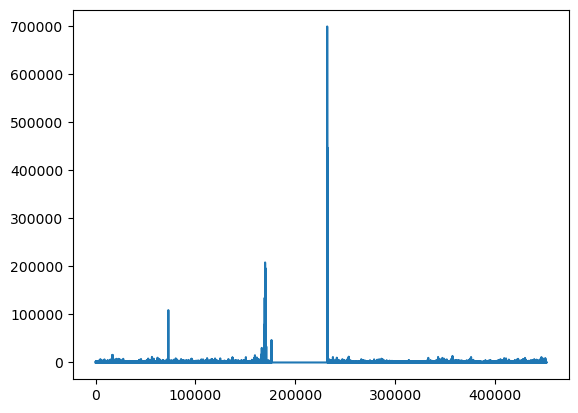

In [82]:
plt.plot(np.arange(len(h3k9me3_signal_nuc)), h3k9me3_signal_nuc)

In [88]:
num_nucs = len(h3k9me3_signal_nuc)

one_mark_cutoff = 220
two_mark_cutoff = one_mark_cutoff*2
print("# NO mark nucs: ", np.sum(h3k9me3_signal_nuc<one_mark_cutoff))
print("# one mark nucs: ", np.sum(1*(h3k9me3_signal_nuc>=one_mark_cutoff) * 1*(h3k9me3_signal_nuc<two_mark_cutoff)))
print("# two mark nucs: ", np.sum(h3k9me3_signal_nuc>=two_mark_cutoff))

# np.sum(h3k9me3_signal_nuc>=two_mark_cutoff)

# NO mark nucs:  189916
# one mark nucs:  99726
# two mark nucs:  161828


In [95]:
1*(h3k9me3_signal_nuc>=one_mark_cutoff) * 1*(h3k9me3_signal_nuc<two_mark_cutoff)

array([0, 0, 0, ..., 0, 0, 0])

In [97]:
marks_1 = np.zeros(num_nucs)

marks_1[np.where(h3k9me3_signal_nuc<one_mark_cutoff)] = 0
marks_1[np.where(1*(h3k9me3_signal_nuc>=one_mark_cutoff) * 1*(h3k9me3_signal_nuc<two_mark_cutoff))] = 1
marks_1[np.where(h3k9me3_signal_nuc>=two_mark_cutoff)] = 2

In [109]:
print("# zero mark nucs: ", np.sum(marks_1==0))
print("# one mark nucs: ",  np.sum(marks_1==1))
print("# two mark nucs: ", np.sum(marks_1==2))


# zero mark nucs:  189916
# one mark nucs:  99726
# two mark nucs:  161828


Text(0, 0.5, '$\\sigma_i^{(1)}$')

<Figure size 640x480 with 0 Axes>

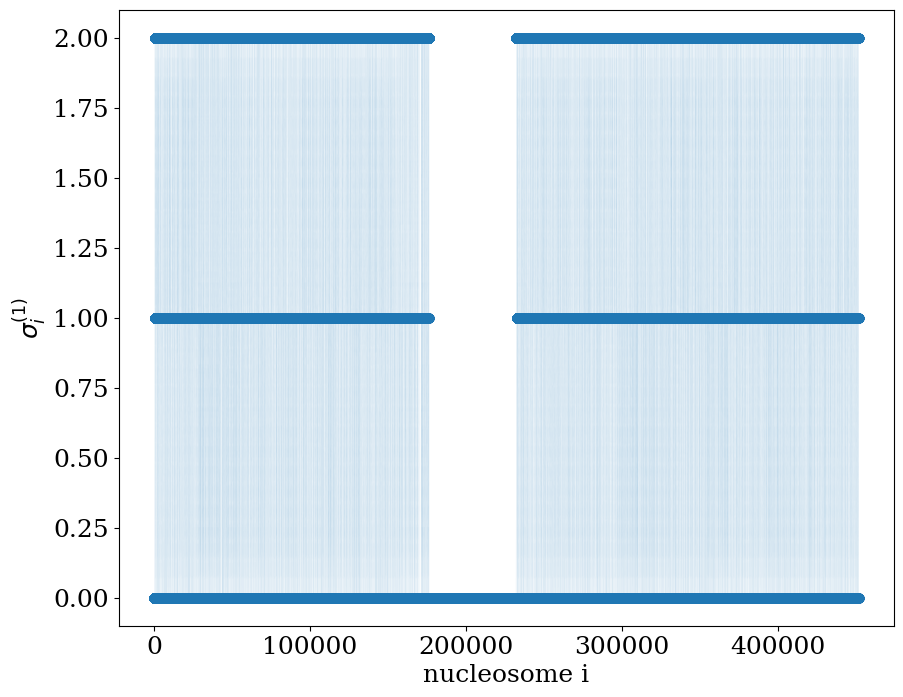

In [356]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(np.arange(len(marks_1)), marks_1, linewidth = 0.01)
plt.scatter(np.arange(len(marks_1)), marks_1)
plt.xlabel("nucleosome i")
plt.ylabel(r"$\sigma_i^{(1)}$")

# 2) Binding profile TODO

implemented a binding model that considers looping behavior (or just self-interaction due to configuration) of chromosome, as opposed to old binding model which does not consider the impact of looping on the interaction (mean field only). Notes on theory in gmail, title "9/18 meeting binding model with looping"

competitive binding model

In [368]:
def calc_s_bind_comp(ws, mus, f_binds):
    f_bind_10, f_bind_01, f_bind_20, f_bind_02, f_bind_11 = f_binds
    mu_1, mu_2 = mus
    # sigma1, sigma2 = sigmas
    w_1, w_2 = ws

    # boltzmann probability of each binding state [s_HP1, s_PRC1]
    p_00 = 1
    p_10 = np.exp(-f_bind_10 + mu_1*1 - w_1*1) 
    p_01 = np.exp(-f_bind_01 + mu_2*1 - w_2*1)
    p_20 = np.exp(-f_bind_20 + mu_1*2 - w_1*2)
    p_02 = np.exp(-f_bind_02 + mu_2*2 - w_2*2)
    p_11 = np.exp(-f_bind_10 + mu_1*1 - w_1*1  - f_bind_01 + mu_2*1 - w_2*1)
    
    q_bind = p_00 + p_01 + p_10 + p_02 + p_20 + p_11 #1. + np.exp(-eps * sigma + mu - w)
    s_bind1 = (1*p_10 + 2*p_20 + 1*p_11) / q_bind #(f_bind_20 + mu_1 - w_1) + 1*(f_bind_11 + mu_1 - w_1 + mu_2 - w_2) / q_bind
    s_bind2 = (1*p_01 + 2*p_02 + 1*p_11) / q_bind #np.exp(1*(f_bind_01 + mu_2 - w_2) + 2*(f_bind_02 + mu_2 - w_2) + 1(*f_bind_11 + mu_1 - w_1 + mu_2 - w_2) / q_bind

    s_binds = [s_bind1, s_bind2]
    return s_binds

# x: genomic distance
# a = 2.6065
# a = 2.6075, mu = -4.8, v_int = -2 : get bridging

def calc_p_loop(x, a=0.01):
    # gaussian looping
    p_loop = a / np.abs(x) ** (1.5)
    
    return p_loop

def calc_p_loop_rubenstein(x, a=0.01):
    # nuclear enviroment looping. Following math of ms end to end multi-scale function
    bp_per_nuc = 190 # bp per nucleosome

    lower_cutoff = 28.89 * 1000 # bp, s1*, from Rubenstein
    upper_cutoff = 399.12 * 1000 # bp, s2*
    lw_cut_nuc = int(lower_cutoff/bp_per_nuc)
    up_cut_nuc = int(upper_cutoff/bp_per_nuc)

    #divide x into three parts 

    #below cutoffs
    index = x <= lw_cut_nuc
    x_lower = x[index]
    p_loop_lower = a / (np.abs(x_lower) ** (1.5))

    #between cutoffs
    index = (x > lw_cut_nuc) * ( x <= up_cut_nuc)
    x_inter = x[index]
    p_1 = p_loop_lower[-1]
    p_loop_inter = p_1 * ( np.abs(x_inter) / lw_cut_nuc)**(-0.75)
    # p_loop_inter = p_loop_lower[-1] + a / np.abs(x_inter) ** (0.75)
    # p_loop_inter = a / np.abs(x_inter) ** (0.75)
    # p_loop_inter -= (p_loop_inter[0] - p_loop_lower[-1])

    #above cutoffs
    index = x > up_cut_nuc
    x_upper = x[index]
    p_2 = p_loop_inter[-1]
    p_loop_upper = p_2 * (np.abs(x_upper)/up_cut_nuc)**(-1.5)

    
    return np.concatenate((p_loop_lower, p_loop_inter, p_loop_upper))
    # return p_loop

Text(0.5, 1.0, 'rubenstein nuclear looping')

<Figure size 640x480 with 0 Axes>

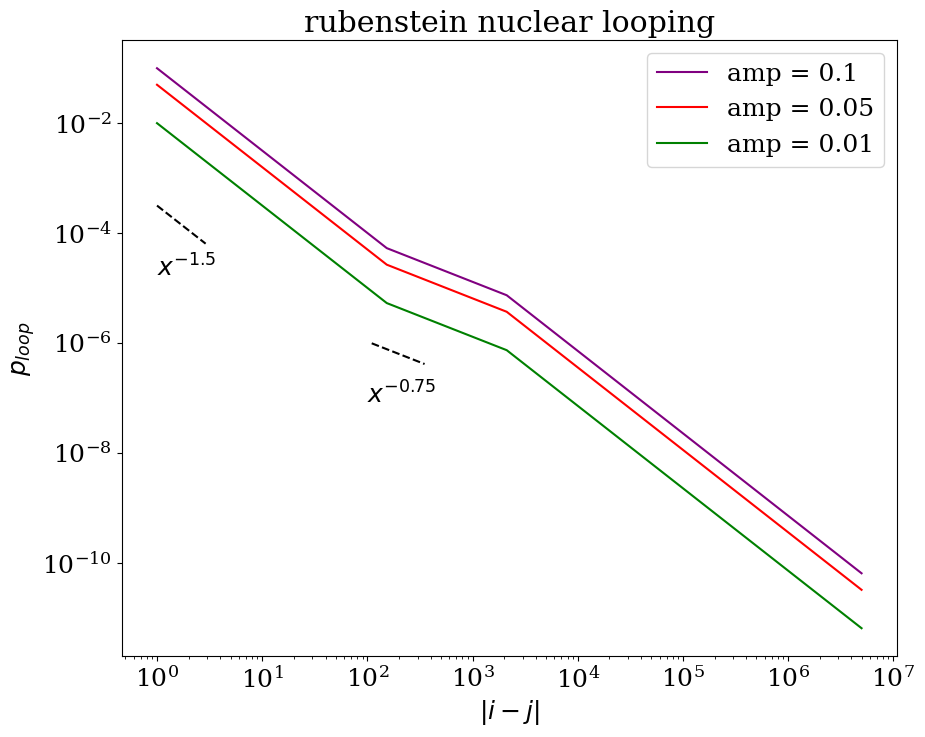

In [370]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.loglog(np.arange(1, 5e6), calc_p_loop_rubenstein(np.arange(1, 5e6), a=.1), label = "amp = 0.1", color = "purple")
plt.loglog(np.arange(1, 5e6), calc_p_loop_rubenstein(np.arange(1, 5e6), a=0.05), label = "amp = 0.05", color = "red")
plt.loglog(np.arange(1, 5e6), calc_p_loop_rubenstein(np.arange(1, 5e6), a=0.01), label = "amp = 0.01", color = "green")
plt.xlabel(r"$| i - j|$")
plt.ylabel(r"$p_{loop}$")

x = np.arange(10,30,1)
xx = np.arange(220000,700000,1)
plt.plot(x*0.1, 0.01*x**-1.5, linestyle = "--", color = "black")#, label = r"$x^{-1.5}$")
plt.plot(xx*0.0005, 0.01* xx**-.75, linestyle = "--", color = "black")#, label = r"$x^{-0.75}$")
plt.text(1,.0016*0.01, r"$x^{-1.5}$")
plt.text(100,.000008*0.01, r"$x^{-0.75}$")
plt.legend()
plt.title("rubenstein nuclear looping")


In [377]:
%%time
# 2 marks competitive, no for loop

v_int = np.array([[-4,0],[0,-4]])
mus = [-2,-100]
e_m = [1.52, 1.52]

marks_2 = np.zeros(len(marks_1))

sigma_1 = marks_1
sigma_2 = marks_2
sigmas = [sigma_1, sigma_2]

n_nuc = len(sigma_1)
n_iter = 100

amp = 0.05 # contact rpobability constant
# e_m = [2, 2]
# v_int = np.array([[-2,0],[0,-2]])

w_1 = np.zeros(n_nuc)
w_2 = np.zeros(n_nuc)
ws = [w_1, w_2]
ws_old = np.copy(ws)

s_arr = np.copy(ws)

f_bind_10 = eval_f_bind_competitive_arr_2([1,0], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
f_bind_01 = eval_f_bind_competitive_arr_2([0,1], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
f_bind_20 = eval_f_bind_competitive_arr_2([2,0], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
f_bind_02 = eval_f_bind_competitive_arr_2([0,2], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
f_bind_11 = eval_f_bind_competitive_arr_2([1,1], sigma_1, sigma_2, e_m, v_int[0, 0],v_int[0, 1],v_int[1, 1])
f_binds_comp = [f_bind_10, f_bind_01, f_bind_20, f_bind_02, f_bind_11]

print("convergence:")
for i in range(n_iter):
    # convergence test
    if (i != 0 and (i%10 == 0)) or (i==1) or (i==n_iter-1):
        ws_1_conv = np.sum(np.abs(ws[0] - ws_old[0]))
        ws_2_conv = np.sum(np.abs(ws[1] - ws_old[1]))
        # print(np.abs(np.sum(ws[0] - ws_old[0])))
        # print(np.abs(np.sum(ws[1] - ws_old[1])))
        print(ws_1_conv + ws_2_conv)
        
    ws_old = np.copy(ws)
    s_old = np.copy(s_arr)
    
    s_arr = calc_s_bind_comp(ws, mus, f_binds_comp) # calcultae binding state of HP1 and PRC1
    # s = calc_s_bind(w, sigma, eps, mu)

    # calculate array of looping probabilitys by nucleosome, with padding for convolution
    i = 0
    p_loop_ini = np.concatenate((np.array([0]),calc_p_loop_rubenstein(np.arange(i + 1, n_nuc)-i, amp)))
    # p_loop_ini = np.concatenate((np.array([0]),calc_p_loop(np.arange(i + 1, n_nuc)-i, amp))) # gaussian looping
    p_loop_reflect = np.concatenate((p_loop_ini[1:][::-1], p_loop_ini))

    # calculate part of interaction energy
    p_s_sum1 = signal.convolve(s_arr[0], p_loop_reflect, mode = "valid") # equivalent to [np.sum(p_loop * s_arr[0])] for i in range (n_nuc)
    p_s_sum2 = signal.convolve(s_arr[1], p_loop_reflect, mode = "valid") # equivalent to [np.sum(p_loop * s_arr[1])] for i in range (n_nuc)

    # calculate mean-field protein conjugate field via saddle point equation
    w_1_fast = v_int[0,0] * p_s_sum1 +  v_int[0,1] * p_s_sum2
    w_2_fast = v_int[1,1] * p_s_sum2 +  v_int[0,1] * p_s_sum1
    ws = [w_1_fast, w_2_fast]

convergence:
280218.8895109871
4887.979679026888
136.11775914905132
6.321553702378642
0.3561577482574029
0.021988609088780087
0.001431101830234427
9.638457227101327e-05
6.64799638605551e-06
4.665155360905615e-07
4.313344037498723e-08
CPU times: total: 17.6 s
Wall time: 46.9 s


In [378]:
s_1, s_2 = s_arr

# factor = 36
# s_1_avgd = np.mean(s_1.reshape(-1, factor), axis=1)
# s_2_avgd = np.mean(s_2.reshape(-1, factor), axis=1)

factor = 500
s_1_avgd = np.mean(s_1[:(len(s_1)//factor)*factor].reshape(-1,factor), axis=1) 
s_2_avgd = np.mean(s_2[:(len(s_2)//factor)*factor].reshape(-1,factor), axis=1) 

Text(0.5, 1.0, '$ \\mu = -2$')

<Figure size 640x480 with 0 Axes>

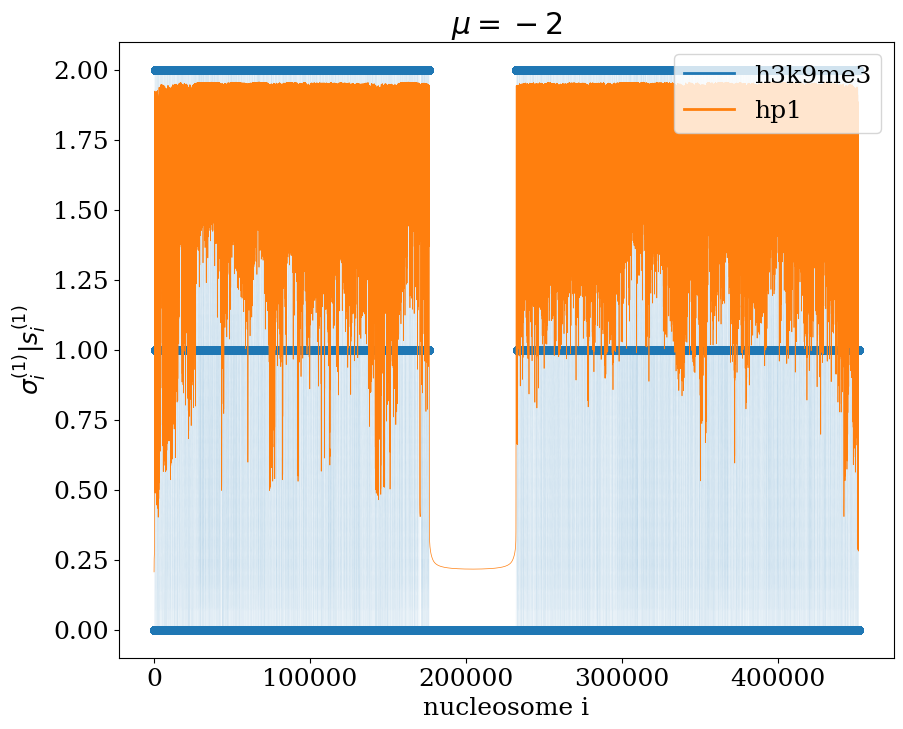

In [431]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

plt.plot(np.arange(len(marks_1)), marks_1, linewidth = 0.01, label = "h3k9me3")
plt.scatter(np.arange(len(marks_1)), marks_1, linewidth = 0.01)
plt.plot(np.arange(len(marks_1)), s_1, linewidth = 0.5, label = "hp1")
plt.xlabel("nucleosome i")
plt.ylabel(r"$\sigma_i^{(1)} | s_i^{(1)}  $")
# plt.legend(linewidth = 1)

# get the legend object
leg = plt.legend(loc=1)

# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(2.0)

plt.title(r"$ \mu = %s$" % mus[0])

<Figure size 640x480 with 0 Axes>

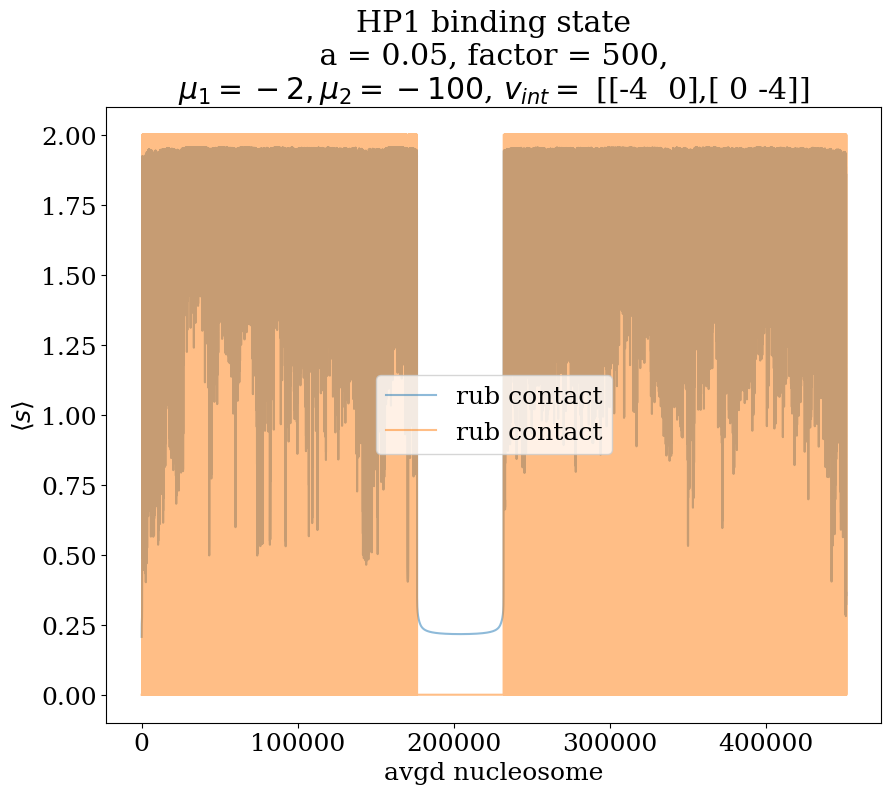

In [391]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.plot(np.arange(n_nuc//factor), s_1_avgd_noloop, alpha = 0.5, label = "no contact")
plt.plot(np.arange(n_nuc), s_1, alpha = 0.5, label = "rub contact")
plt.plot(np.arange(n_nuc), marks_1, alpha = 0.5, label = "rub contact")
# plt.plot(np.arange(n_nuc//factor), s_1_avgd_chromo, alpha = 0.5, label = "chromo")
plt.title("HP1 binding state" + "\n" \
          + " a = %s, factor = %s, " % (amp, factor) + "\n" \
          "$\mu_1 = %s, \mu_2 = %s$," % (mus[0], mus[1])  \
          +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" )
plt.xlabel("avgd nucleosome")
plt.ylabel(r"$ \langle s \rangle$")
plt.legend()

<Figure size 640x480 with 0 Axes>

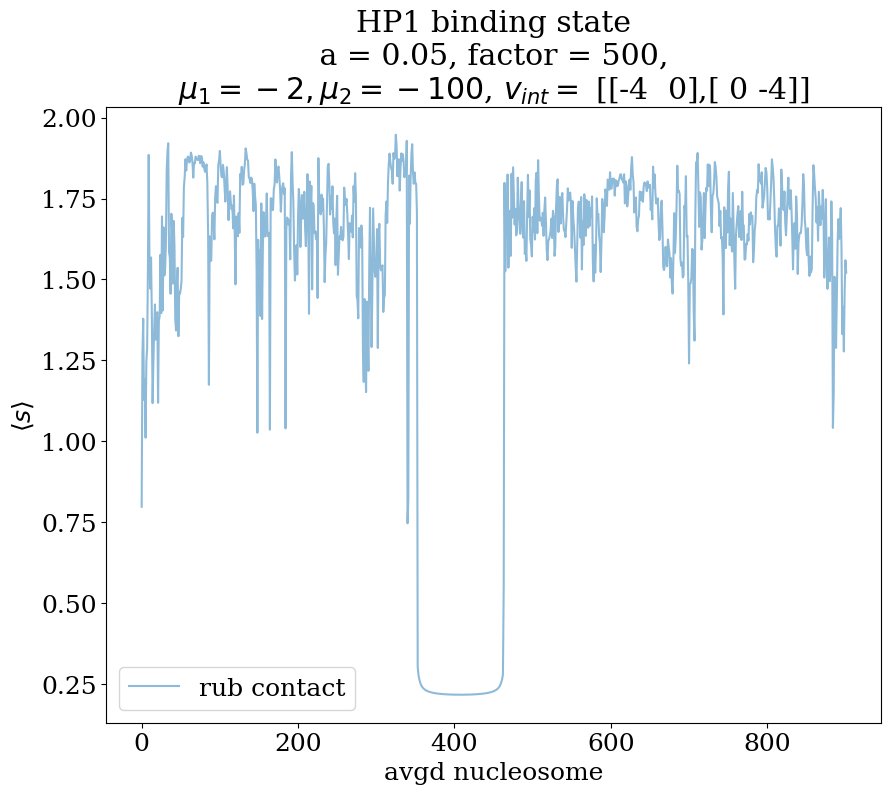

In [379]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# plt.plot(np.arange(n_nuc//factor), s_1_avgd_noloop, alpha = 0.5, label = "no contact")
plt.plot(np.arange(n_nuc//factor), s_1_avgd, alpha = 0.5, label = "rub contact")
# plt.plot(np.arange(n_nuc//factor), s_1_avgd_chromo, alpha = 0.5, label = "chromo")
plt.title("HP1 binding state" + "\n" \
          + " a = %s, factor = %s, " % (amp, factor) + "\n" \
          "$\mu_1 = %s, \mu_2 = %s$," % (mus[0], mus[1])  \
          +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" )
plt.xlabel("avgd nucleosome")
plt.ylabel(r"$ \langle s \rangle$")
plt.legend()

In [387]:
# fig = plt.figure()
# plt.figure(figsize=(10,8))

# font = {'family' : 'serif',
#         'weight':'normal',
#         'size': 18}
# plt.rc('font', **font)

# # plt.plot(np.arange(n_nuc//factor), s_2_avgd_noloop, alpha = 0.5, label = "no contact")
# plt.plot(np.arange(n_nuc//factor), s_2_avgd, alpha = 0.5, label = "rub contact")
# # plt.plot(np.arange(n_nuc//factor), s_2_avgd_chromo, alpha = 0.5, label = "chromo")

# plt.title("PRC1 binding state" + "\n" \
#           + " a = %s, factor = %s, " % (amp, factor) + "\n" \
#           "$\mu_1 = %s, \mu_2 = %s$," % (mus[0], mus[1])  \
#           +  " $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" )
# plt.xlabel("avgd nucleosome")
# plt.ylabel(r"$ \langle s \rangle$")
# plt.legend()

# 3) Get the Hi-C

In [ ]:
# Get normalized observed, then normalized expected then do O/E analysis

In [224]:
Hi_c_raw_obs = pd.read_csv(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_1mb.RAWobserved", sep="\t", header=None)
Hi_c_raw_obs.columns = ["i","j",r"$M_{ij}$"]
Hi_c_KRnorm = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_1mb.KRnorm")

# Hi_c_raw_exp = pd.read_csv(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_1mb.RAWexpected", sep="\t", header=None)
# Hi_c_raw_exp.columns = ["i","j",r"$M_{ij}$"]
Hi_c_KRexpected = np.loadtxt(r"C:\Users\tmhab\wlcsim_membrane\config_binding\Hi-C_data_chr_16\chr16_1mb.KRexpected")
resolution = 1e6 #1mb

In [228]:
Hi_c_raw_obs#[r"$M_{ij}$"].values

,i,j,$M_{ij}$
0,0,0,427176.0
1,0,1000000,107415.0
2,1000000,1000000,431344.0
3,0,2000000,29197.0
4,1000000,2000000,82222.0
...,...,...,...
3316,86000000,90000000,1675.0
3317,87000000,90000000,3349.0
3318,88000000,90000000,6295.0
3319,89000000,90000000,34619.0


In [262]:
# (Hi_c_KRnorm[(Hi_c_raw_obs["i"].values // 1e6).astype(int)])
# Hi_c_KRnorm[(Hi_c_raw_obs["j"].values // 1e6).astype(int)]

## KR normalization of observed Hi-C data

In [265]:
# Hi_c_KRnorm#.values

In [276]:
# Hi_c_Kr_obs = M_ij / (Hi_c_KRnorm[ i value int divide by 1e7]*Hi_c_KRnorm[ j value int divide by 1e7])

Hi_c_Kr_obs = Hi_c_raw_obs[r"$M_{ij}$"].values / (Hi_c_KRnorm[(Hi_c_raw_obs["i"].values // resolution).astype(int)]*Hi_c_KRnorm[(Hi_c_raw_obs["j"].values // resolution).astype(int)])

In [278]:
Hi_c_Kr_obs

array([442732.35437198, 104734.43314127, 395674.85574671, ...,
        19347.5726569 ,  88154.06351783, 508568.61140395])

In [280]:
Hi_c_raw_obs[r"$M_{ij}^{KR}$"] = Hi_c_Kr_obs

## Obs/Exp

In [283]:
# observed/expected correction
i_j_diff = Hi_c_raw_obs["i"].values - Hi_c_raw_obs["j"].values
Kr_indices = (i_j_diff // resolution).astype(int)
Hi_c_Kr_OE = Hi_c_Kr_obs / Hi_c_KRexpected[Kr_indices]

In [285]:
Hi_c_Kr_OE

array([  1.52154513, 116.37401554,   1.35982189, ...,  27.05379845,
        97.95099902,   1.74780561])

In [287]:
Hi_c_raw_obs[r"$(O/E)^{KR}$"] = Hi_c_Kr_OE

In [289]:
Hi_c_raw_obs

,i,j,$M_{ij}$,$M_{ij}^{KR}$,$(O/E)^{KR}$
0,0,0,427176.0,442732.354372,1.521545
1,0,1000000,107415.0,104734.433141,116.374016
2,1000000,1000000,431344.0,395674.855747,1.359822
3,0,2000000,29197.0,29398.647419,41.108262
4,1000000,2000000,82222.0,77887.415663,86.543375
...,...,...,...,...,...
3316,86000000,90000000,1675.0,4492.213135,7.950041
3317,87000000,90000000,3349.0,8762.988778,14.198594
3318,88000000,90000000,6295.0,19347.572657,27.053798
3319,89000000,90000000,34619.0,88154.063518,97.950999


## plotting

<Figure size 640x480 with 0 Axes>

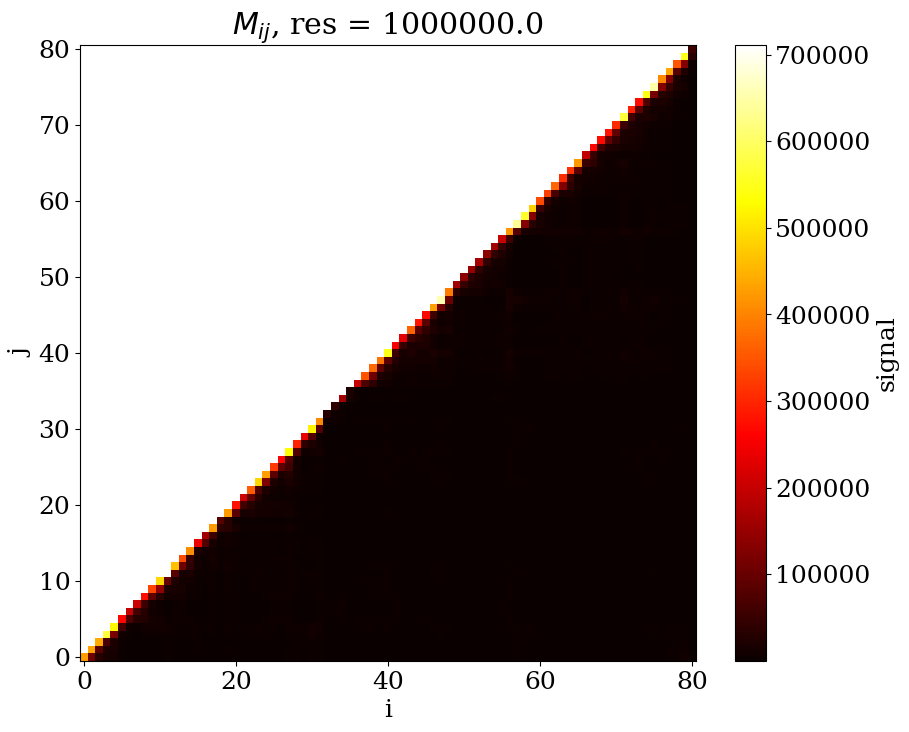

In [336]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# 1. Create a pivot table to reshape the data into a grid for the heatmap
heatmap_data = Hi_c_raw_obs.pivot(columns='j', index='i', values=r'$M_{ij}$')

# 2. Plot the heatmap using imshow
plt.imshow(heatmap_data, cmap='hot', interpolation='nearest', origin='lower')

# Add color bar to indicate intensity values
plt.colorbar(label='signal')

# 3. Add labels and title
plt.xlabel('i')
plt.ylabel('j')
plt.title(r'$M_{ij}$, res = %s' % resolution)

# Show the plot
plt.show()

<Figure size 640x480 with 0 Axes>

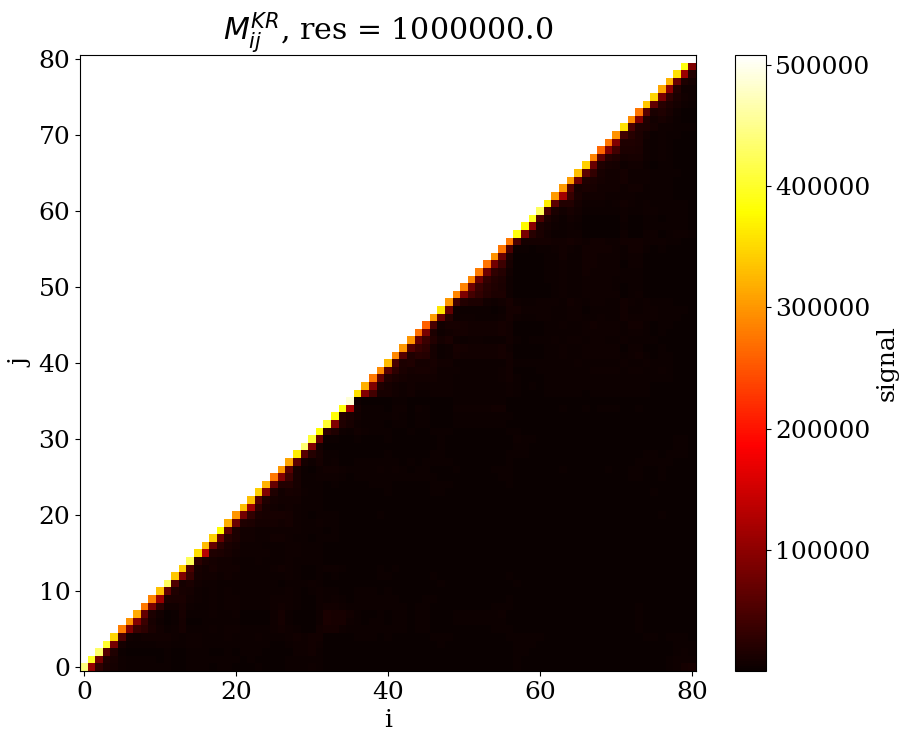

In [334]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# 1. Create a pivot table to reshape the data into a grid for the heatmap
heatmap_data = Hi_c_raw_obs.pivot(columns='j', index='i', values=r'$M_{ij}^{KR}$')

# 2. Plot the heatmap using imshow
plt.imshow(heatmap_data, cmap='hot', interpolation='nearest', origin='lower')

# Add color bar to indicate intensity values
plt.colorbar(label='signal')

# 3. Add labels and title
plt.xlabel('i')
plt.ylabel('j')
plt.title(r'$M_{ij}^{KR}$, res = %s' % resolution)

# Show the plot
plt.show()

<Figure size 640x480 with 0 Axes>

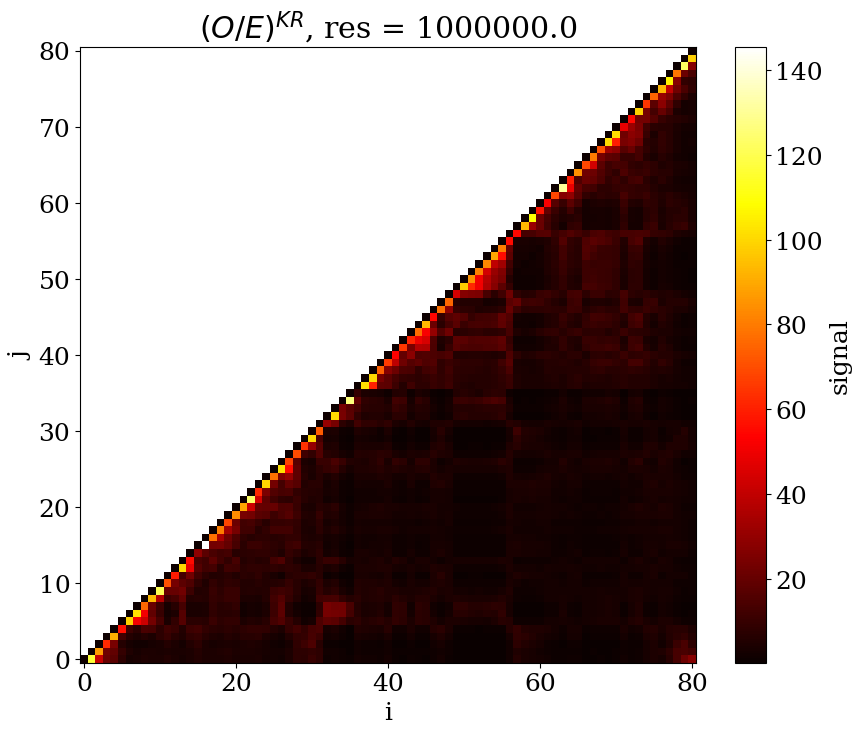

In [330]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)

# 1. Create a pivot table to reshape the data into a grid for the heatmap
heatmap_data = Hi_c_raw_obs.pivot(columns='j', index='i', values=r"$(O/E)^{KR}$")

# 2. Plot the heatmap using imshow
plt.imshow(heatmap_data, cmap="hot", interpolation='nearest', origin='lower')

# Add color bar to indicate intensity values
plt.colorbar(label='signal')

# 3. Add labels and title
plt.xlabel('i')
plt.ylabel('j')
plt.title(r"$(O/E)^{KR}$, res = %s" % resolution)

# Show the plot
plt.show()

# 4) Neural Net TODO

# OLD ANALYSIS:

In [60]:
# chr16_h3k9me3_data["truePeak"] = chr16_h3k9me3_data.start + chr16_h3k9me3_data.peak

C:\Users\tmhab\AppData\Local\Temp\ipykernel_59780\3188263119.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr16_h3k9me3_data["truePeak"] = chr16_h3k9me3_data.start + chr16_h3k9me3_data.peak


In [66]:
chr16_h3k9me3_data

,chromosome,start,end,name,score,strand,signalValue,pValue,qValue,peak,truePeak
25155,chr16,656350,657479,25357,20752,.,7.80,1.145499,1.849896,819,657169
16612,chr16,868391,869323,16735,13542,.,10.98,1.920481,2.748215,385,868776
10010,chr16,888869,892430,10085,22621,.,7.80,0.998783,1.696672,1043,889912
11661,chr16,933213,936229,11747,16925,.,5.23,1.474529,2.245336,1847,935060
18119,chr16,964197,965558,18248,14769,.,10.80,1.771422,2.543868,455,964652
...,...,...,...,...,...,...,...,...,...,...,...
16346,chr16,89972483,89974030,16468,11310,.,8.32,2.343439,3.201511,1267,89973750
22944,chr16,89974144,89975316,23124,16714,.,7.97,1.504982,2.272023,378,89974522
19268,chr16,90057181,90059622,19412,54489,.,6.60,0.196881,0.647289,2202,90059383
989,chr16,90059712,90063610,993,318,.,11.79,7.582638,7.793694,1204,90060916


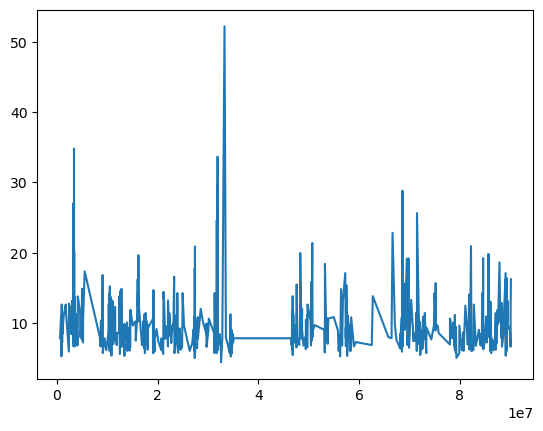

In [70]:
plt.plot(chr16_h3k9me3_data.truePeak.values, chr16_h3k9me3_data.signalValue)

In [112]:
chr16_h3k9me3_data["nuc"] = chr16_h3k9me3_data.truePeak.values // 200
chr16_h3k9me3_data

C:\Users\tmhab\AppData\Local\Temp\ipykernel_59780\201173917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr16_h3k9me3_data["nuc"] = chr16_h3k9me3_data.truePeak.values // 200


,chromosome,start,end,name,score,strand,signalValue,pValue,qValue,peak,truePeak,nuc
25155,chr16,656350,657479,25357,20752,.,7.80,1.145499,1.849896,819,657169,3285
16612,chr16,868391,869323,16735,13542,.,10.98,1.920481,2.748215,385,868776,4343
10010,chr16,888869,892430,10085,22621,.,7.80,0.998783,1.696672,1043,889912,4449
11661,chr16,933213,936229,11747,16925,.,5.23,1.474529,2.245336,1847,935060,4675
18119,chr16,964197,965558,18248,14769,.,10.80,1.771422,2.543868,455,964652,4823
...,...,...,...,...,...,...,...,...,...,...,...,...
16346,chr16,89972483,89974030,16468,11310,.,8.32,2.343439,3.201511,1267,89973750,449868
22944,chr16,89974144,89975316,23124,16714,.,7.97,1.504982,2.272023,378,89974522,449872
19268,chr16,90057181,90059622,19412,54489,.,6.60,0.196881,0.647289,2202,90059383,450296
989,chr16,90059712,90063610,993,318,.,11.79,7.582638,7.793694,1204,90060916,450304


In [152]:
chr16_h3k9me3_data["nuc_start"] = chr16_h3k9me3_data.start.values // 200
chr16_h3k9me3_data["nuc_end"] = chr16_h3k9me3_data.end.values // 200
chr16_h3k9me3_data

C:\Users\tmhab\AppData\Local\Temp\ipykernel_59780\3824968197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr16_h3k9me3_data["nuc_start"] = chr16_h3k9me3_data.start.values // 200
C:\Users\tmhab\AppData\Local\Temp\ipykernel_59780\3824968197.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chr16_h3k9me3_data["nuc_end"] = chr16_h3k9me3_data.end.values // 200


,chromosome,start,end,name,score,strand,signalValue,pValue,qValue,peak,nuc_start,nuc_end
2979,chr16,2357706,2357835,Peak_18719,31,.,3.36350,3.15500,0.09098,50,11788,11789
3009,chr16,3077832,3077972,Peak_503,87,.,6.40491,8.73385,3.47371,89,15389,15389
3046,chr16,3223578,3223688,Peak_4718,58,.,4.77506,5.80953,1.61630,54,16117,16118
3047,chr16,3223793,3224036,Peak_789,81,.,6.05377,8.11092,3.07401,80,16118,16120
3048,chr16,3224096,3225075,Peak_911,79,.,5.62315,7.99793,3.01658,583,16120,16125
...,...,...,...,...,...,...,...,...,...,...,...,...
3183,chr16,89129792,89129902,Peak_8870,49,.,4.47311,4.98348,0.99766,33,445648,445649
3184,chr16,89226618,89226752,Peak_2479,63,.,5.12545,6.35717,1.86798,40,446133,446133
3185,chr16,89249988,89250098,Peak_6899,50,.,4.49746,5.02485,0.99766,93,446249,446250
3186,chr16,89376904,89377093,Peak_19404,27,.,3.13807,2.73789,0.00000,40,446884,446885


In [154]:
np.sum(chr16_h3k9me3_data.nuc_end.values - chr16_h3k9me3_data.nuc_start.values)

262

## max of 8649 nucleosomes with marks. WAY To LOW

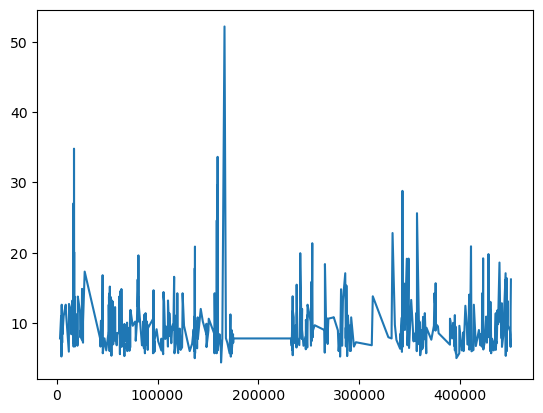

In [116]:
plt.plot(chr16_h3k9me3_data.nuc.values, chr16_h3k9me3_data.signalValue.values)

In [124]:
np.sum(chr16_h3k9me3_data.signalValue.values<50)

668

In [142]:
# chr16_h3k9me3_data.signalValue.values

In [118]:
chr16_h3k9me3_arr = np.zeros(450606)


array([0., 0., 0., ..., 0., 0., 0.])